# Machine Learning on a Public Dataset

Train and Evaluate the machine learning models

## Importing the required libraries

In [13]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss
# local modules
from src.data_pipeline import BrainDataset
from src.losses import *
from src.models import UNet, AttentionGatedUNet, DeformableUNet, AttentionGatedDeformableUNet
from src.utils import train_one_epoch, evaluate, export2onnx, WarmupCosineAnnealingLR

## Visualizing the WarmupCossineAnnealing learning rate scheduler

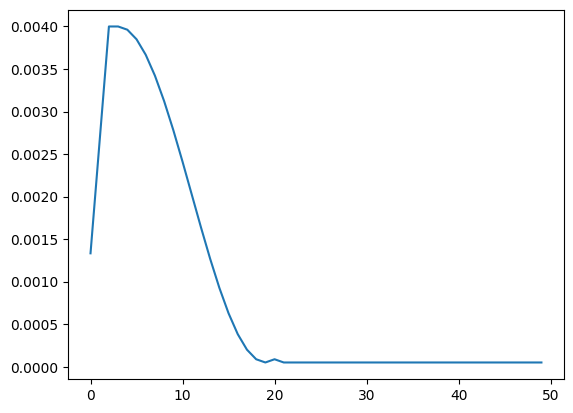

In [14]:
dummy_model = torch.nn.Sequential(torch.nn.Linear(32, 32))
dummy_opt = torch.optim.SGD(dummy_model.parameters(), lr=4e-3, momentum=.9, nesterov=True)
dummy_scheduler = WarmupCosineAnnealingLR(dummy_opt, 1, warmup_epoch=3, epochs=20, min_lr=5e-5)

lrs = []
for ep in range(50):
    lrs.append(*dummy_scheduler.get_lr())
    dummy_opt.step()
    dummy_scheduler.step()

plt.plot(lrs)
plt.show()

## Building the data pipeline

In [15]:
class RescaleMask:
    def __call__(self, img: torch.Tensor):
        assert img.min() >=0 and img.max() <= 1
        return img.clamp(min=0, max=1)


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleMask()
])

train_loader = BrainDataset(True, transforms.ToTensor(), mask_transform)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
test_loader = BrainDataset(False, transforms.ToTensor(), mask_transform)
test_loader = DataLoader(test_loader, batch_size=64, shuffle=False)

## Building and Training UNet

In [16]:
model = DeformableUNet(in_channels=3, features=32)

loss = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
scheduler = WarmupCosineAnnealingLR(optimzer=optimizer, multiplier=1, warmup_epoch=3, epochs=20, min_lr=5e-5)

min_test_loss = 1e10
early_stopping_counter, patience = 0, 4
writer = SummaryWriter()

for epoch in range(100):
    print(f'---------Epoch {epoch + 1}---------')
    print(f'Current learning rate: {scheduler.get_last_lr()[0]}')
    train_loss = train_one_epoch(model, loss, optimizer, train_loader)
    scheduler.step()
    writer.add_scalar('Loss/Train', train_loss, epoch)
    test_loss, test_miou, test_sensitivity, test_specificity, j_index = evaluate(model, loss, test_loader)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('mIoU/Test', test_miou, epoch)
    writer.add_scalar('Sensitivity/Test', test_sensitivity, epoch)
    writer.add_scalar('Specificity/Test', test_specificity, epoch)
    writer.add_scalar("Youden's J Index/Test", j_index, epoch)
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        early_stopping_counter = 0
        torch.save(model, 'models/model.pth')
    else:
        early_stopping_counter += 1
        # early stopping
        if early_stopping_counter > patience:
            break

---------Epoch 1---------
Current learning rate: 0.0016666666666666666
loss: 1.10786 [64/3205]
loss: 0.99791 [1664/3205]
loss: 0.93583 [3205/3205]
Test Metrics: 
    Loss: 1.04494 mIoU: 0.68047 Sensitivity: 0.75713 Specificity: 0.99611 Youden's J Index: 0.75324
---------Epoch 2---------
Current learning rate: 0.003333333333333333
loss: 0.93933 [64/3205]
loss: 0.78934 [1664/3205]
loss: 1.03058 [3205/3205]
Test Metrics: 
    Loss: 0.68512 mIoU: 0.72212 Sensitivity: 0.74672 Specificity: 0.99826 Youden's J Index: 0.74498
---------Epoch 3---------
Current learning rate: 0.005
loss: 0.41610 [64/3205]
loss: 0.40189 [1664/3205]
loss: 0.17213 [3205/3205]
Test Metrics: 
    Loss: 1.48561 mIoU: 0.25701 Sensitivity: 0.86817 Specificity: 0.92420 Youden's J Index: 0.79238
---------Epoch 4---------
Current learning rate: 0.005
loss: 0.40540 [64/3205]
loss: 0.32052 [1664/3205]
loss: 0.39626 [3205/3205]
Test Metrics: 
    Loss: 0.59883 mIoU: 0.67811 Sensitivity: 0.78133 Specificity: 0.99864 Youden's J 

## Visual validation of UNet model

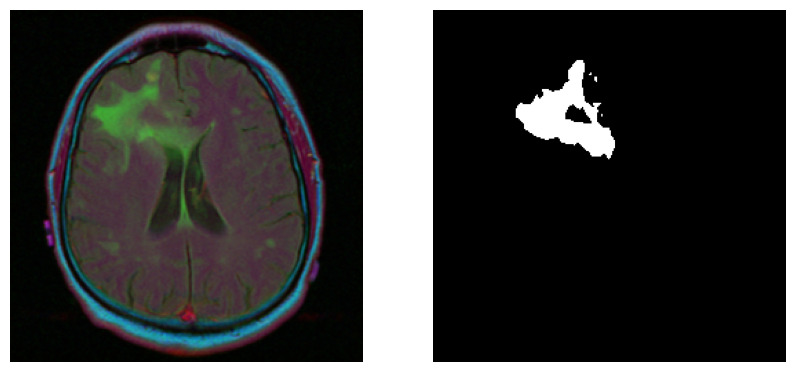

In [17]:
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
transform = transforms.ToTensor()
img = transform(img)
img = img.unsqueeze(0)
assert img.shape == (1, 3, 256, 256)

model = torch.load('models/model.pth')
model.eval()
device = torch.device('cuda')
pred = (model(img.to(device)) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0)
assert pred.shape == (1, 256, 256)
pred = pred.squeeze()
assert pred.shape == (256, 256)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
assert pred.min() >= 0 and pred.max() <= 1
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(pred, cmap='gray')
ax2.axis('off')
plt.show()

# Exporting the trained models to ONNX

In [18]:
export2onnx(
    model=model,
    model_name='models/unet.onnx',
    input_shape=(1, 3, 256, 256)
)